In [ ]:
!pip install torch

In [ ]:
!pip install torchvision

In [ ]:
import torch

print(torch.cpu.is_available())
print(torch.cuda.is_available())

True
True


In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [ ]:
import struct
import sys
from array import array
from os import path
import torchvision
import os
import numpy as np
from PIL import Image

MNIST_PATH = 'content/raw_mnist'

train_mnist = torchvision.datasets.MNIST(root=MNIST_PATH, train=True,  download=True)
test_minst  = torchvision.datasets.MNIST(root=MNIST_PATH, train=False, download=True)

def read(dataset):
    if dataset == 'training':
        path_img = MNIST_PATH+"/MNIST/raw/train-images-idx3-ubyte"
        path_lbl = MNIST_PATH+"/MNIST/raw/train-labels-idx1-ubyte"
    elif dataset == "testing":
        path_img = MNIST_PATH+"/MNIST/raw/t10k-images-idx3-ubyte"
        path_lbl = MNIST_PATH+"/MNIST/raw/t10k-labels-idx1-ubyte"
    else:
        raise Exception("unknown dataset")

    with open(path_lbl, 'rb' ) as f_label:
        _, size = struct.unpack(">II", f_label.read(8))
        lbl=array("b", f_label.read())

    with open(path_img, 'rb' ) as f_img:
        _, size, rows, cols = struct.unpack(">IIII", f_img.read(16))
        img=array("B", f_img.read())

    return lbl, img, size, rows, cols


def write_dataset(labels, data, size, rows, cols, output_dir):
    classes = {i: f"class_{i}" for i in range(10)}

    output_dirs = [
        path.join(output_dir, classes[i])  for i in range (10)
    ]
    for dir in output_dirs:
            if not path.exists(dir):
                os.makedirs(dir)

    for(i, label) in enumerate(labels):
        output_filename = path.join(output_dirs[label] , str(i)+".jpg")
        #printing is too slow
        #print("writing " + output_filename)

        with open(output_filename, "wb") as h:
            data_i = [
                data[ (i*rows*cols + j*cols): (i*rows*cols + (j+1)*cols)]
                for j in range(rows)
            ]
            data_array= np.asarray(data_i)
            im = Image.fromarray(data_array)
            im.save(output_filename)

output_path = "content/mnist"

for dataset in ["training", "testing"]:
    write_dataset(*read(dataset), path.join(output_path, dataset))

In [ ]:
class MNISTDataset(Dataset):
  """Класс для формирование данных"""
  def __init__(self, path, transform=None):
    """Конструктор класса"""
    self.path = path
    self.transform = transform

    self.len_dataset = 0
    self.data_list = []

    for path_dir, dir_list, file_list in os.walk(path):
      if path_dir == path:
        self.classes = sorted(dir_list) #свойство классес - список с именами вложенных папок
        self.class_to_idx = {
            cls_name: i for i, cls_name in enumerate(self.classes) #словарь, где ключ - название класса, значение - номер
        }
        continue

      cls = path_dir.split('/')[-1]

      for name_file in file_list:
        file_path = os.path.join(path_dir, name_file)
        self.data_list.append((file_path, self.class_to_idx[cls])) #в список добавляется кортеж: (путь до файла, позиция в one_hot векторе для данного файла)

      self.len_dataset += len(file_list)

  def __len__(self):
    """Получаем длину данного класса"""
    return self.len_dataset

  def __getitem__(self, index):
    """По индексу получаем пару ('данные', 'ответ к данным')"""
    file_path, target = self.data_list[index]
    sample = Image.open(file_path)

    if self.transform is not None:
      sample = self.transform(sample)
    return sample, target

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [ ]:
train_data = MNISTDataset(path='/content/content/mnist/training', transform=transform)
test_data = MNISTDataset(path='/content/content/mnist/testing', transform=transform)

In [ ]:
train_data, val_data = random_split(train_data, [0.8, 0.2]) #разбиваем тренировочный датасет на тренировачный и валидационный 80 на 20

print(f"Длина тренировочного датасета: {len(train_data)}")
print(f"Длина валидационного датасета: {len(val_data)}")
print(f"Длина тестового датасета: {len(test_data)}")

Длина тренировочного датасета: 48000
Длина валидационного датасета: 12000
Длина тестового датасета: 10000


In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
class NN(nn.Module):
  """Класс модели нейронной сети"""
  def __init__(self):
    """Описание слоев и функций активации"""
    super().__init__()
    self.fc1 = nn.Linear(28*28, 512)
    self.bn1 = nn.BatchNorm1d(512)
    self.fc2 = nn.Linear(512, 256)
    self.bn2 = nn.BatchNorm1d(256)
    self.fc3 = nn.Linear(256, 128)
    self.bn3 = nn.BatchNorm1d(128)
    self.fc4 = nn.Linear(128, 10)

    self.dropout = nn.Dropout(0.3)
    self.relu = nn.ReLU()

  def forward(self, x):
    """Описывается архитектура модели"""
    x = x.view(x.size(0), -1)
    x = self.dropout(self.relu(self.bn1(self.fc1(x))))
    x = self.dropout(self.relu(self.bn2(self.fc2(x))))
    x = self.dropout(self.relu(self.bn3(self.fc3(x))))
    out = self.fc4(x)
    return out

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' #Графический процессор, если он доступен
model = NN().to(device) #Создание модели

In [ ]:
loss_model = nn.CrossEntropyLoss() #Функция потерь
opt = torch.optim.Adam(model.parameters(), lr=0.0001) #Оптимизатор градиентного спуска

In [ ]:
#Начало обучения
EPOCHS = 20
train_loss = []
train_acc = []
val_loss = []
val_acc = []
all_targets = []
all_preds = []
#Цикл
for epoch in range(EPOCHS):
  #Тренировка
  model.train()
  running_train_loss = []
  true_answer = 0
  train_loop = tqdm(train_loader, leave=False) #Полоса загрузки
  #Данные
  for x, targets in train_loop:
    x = x.to(device)
    targets = targets.to(device)

    #Прямой проход + расчет ошибки модели
    pred = model(x)
    loss = loss_model(pred, targets)

    #Обратный проход
    opt.zero_grad()
    loss.backward()

    #Шаг оптимизации
    opt.step()
    running_train_loss.append(loss.item())
    mean_train_loss = sum(running_train_loss)/len(running_train_loss)
    true_answer += (torch.argmax(pred, dim=1) == targets).sum().item()
    train_loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss:.4f}")

  #Расчет значения метрики
  running_train_acc = true_answer / len(train_data)

  #Сохранение
  train_loss.append(mean_train_loss)
  train_acc.append(running_train_acc)

  #Валидация
  model.eval()
  with torch.no_grad():
    running_val_loss = []
    true_answer = 0
    all_targets = []
    all_preds = []

    for x, targets in val_loader:
        x = x.to(device)
        targets = targets.to(device)

        pred = model(x)
        loss = loss_model(pred, targets)

        running_val_loss.append(loss.item())
        mean_val_loss = sum(running_val_loss) / len(running_val_loss)

        # собираем предсказания
        preds = torch.argmax(pred, dim=1)

        true_answer += (preds == targets).sum().item()

        all_targets.extend(targets.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    #Расчет значения метрики
    running_val_acc = true_answer / len(val_data)
    val_loss.append(mean_val_loss)
    val_acc.append(running_val_acc)

    print(f"Final Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss:.4f}, train_acc={running_train_acc:.4f}, val_loss={mean_val_loss:.4f}, val_acc={running_val_acc:.4f}")

Final Epoch [1/20], train_loss=0.6766, train_acc=0.8396, val_loss=0.2120, val_acc=0.9436


Final Epoch [2/20], train_loss=0.2700, train_acc=0.9276, val_loss=0.1295, val_acc=0.9607


Final Epoch [3/20], train_loss=0.1958, train_acc=0.9442, val_loss=0.1006, val_acc=0.9697


Final Epoch [4/20], train_loss=0.1585, train_acc=0.9537, val_loss=0.0864, val_acc=0.9735


Final Epoch [5/20], train_loss=0.1384, train_acc=0.9593, val_loss=0.0797, val_acc=0.9753


Final Epoch [6/20], train_loss=0.1238, train_acc=0.9621, val_loss=0.0776, val_acc=0.9767


Final Epoch [7/20], train_loss=0.1157, train_acc=0.9649, val_loss=0.0786, val_acc=0.9767


Final Epoch [8/20], train_loss=0.1041, train_acc=0.9682, val_loss=0.0704, val_acc=0.9788


Final Epoch [9/20], train_loss=0.0981, train_acc=0.9694, val_loss=0.0655, val_acc=0.9799


Final Epoch [10/20], train_loss=0.0890, train_acc=0.9721, val_loss=0.0614, val_acc=0.9814


Final Epoch [11/20], train_loss=0.0853, train_acc=0.9741, val_loss=0.0624, val_acc=0.9817


Final Epoch [12/20], train_loss=0.0795, train_acc=0.9750, val_loss=0.0610, val_acc=0.9815


Final Epoch [13/20], train_loss=0.0766, train_acc=0.9755, val_loss=0.0641, val_acc=0.9808


Final Epoch [14/20], train_loss=0.0722, train_acc=0.9776, val_loss=0.0609, val_acc=0.9818


Final Epoch [15/20], train_loss=0.0645, train_acc=0.9799, val_loss=0.0608, val_acc=0.9826


Final Epoch [16/20], train_loss=0.0644, train_acc=0.9799, val_loss=0.0582, val_acc=0.9819


Final Epoch [17/20], train_loss=0.0620, train_acc=0.9804, val_loss=0.0570, val_acc=0.9834


Final Epoch [18/20], train_loss=0.0577, train_acc=0.9816, val_loss=0.0621, val_acc=0.9822


Final Epoch [19/20], train_loss=0.0547, train_acc=0.9831, val_loss=0.0552, val_acc=0.9831


Final Epoch [20/20], train_loss=0.0554, train_acc=0.9819, val_loss=0.0567, val_acc=0.9833


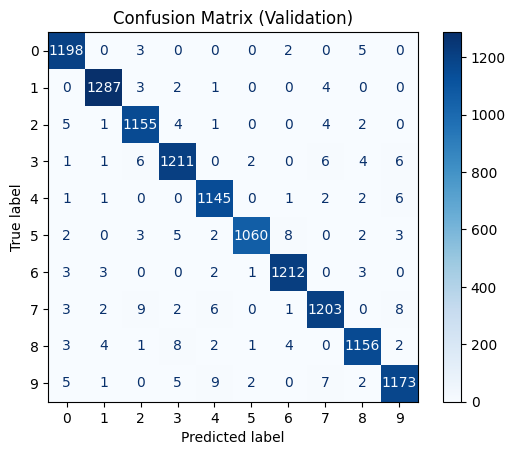

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Validation)")
plt.show()

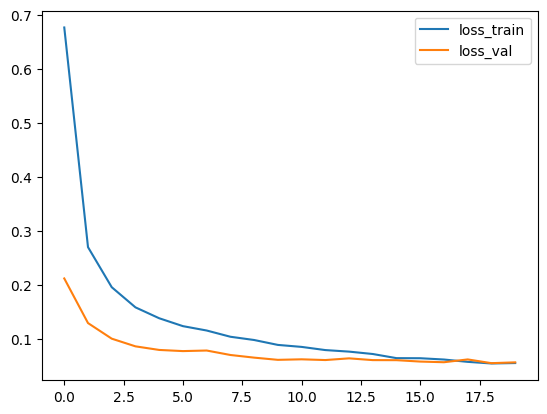

In [ ]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['loss_train', 'loss_val'])
plt.show()

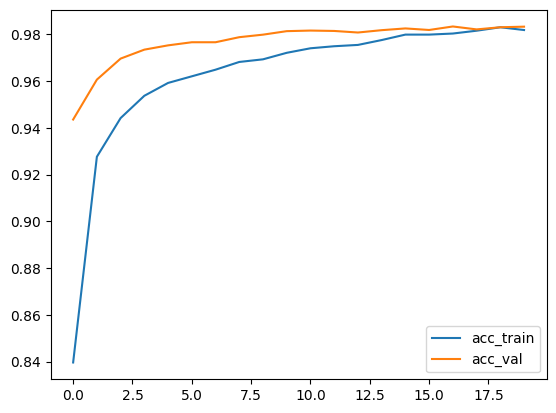

In [ ]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['acc_train', 'acc_val'])
plt.show()

In [ ]:
def show_correct_and_wrong(model, loader, classes, device, num_correct=5, num_wrong=5):
    model.eval()
    correct_samples = []
    wrong_samples = []

    with torch.no_grad():
        for x, targets in loader:
            x = x.to(device)
            targets = targets.to(device)
            outputs = model(x)
            preds = torch.argmax(outputs, dim=1)

            for i in range(len(targets)):
                img = x[i].cpu()
                true_label = targets[i].item()
                pred_label = preds[i].item()

                if true_label == pred_label and len(correct_samples) < num_correct:
                    correct_samples.append((img, true_label, pred_label))
                elif true_label != pred_label and len(wrong_samples) < num_wrong:
                    wrong_samples.append((img, true_label, pred_label))

                # если набрали достаточно примеров — выходим
                if len(correct_samples) >= num_correct and len(wrong_samples) >= num_wrong:
                    break
            if len(correct_samples) >= num_correct and len(wrong_samples) >= num_wrong:
                break

    # рисуем
    total = num_correct + num_wrong
    plt.figure(figsize=(15, 6))
    samples = correct_samples + wrong_samples
    for i, (img, true_label, pred_label) in enumerate(samples):
        plt.subplot(2, total // 2, i + 1)
        img = img.permute(1, 2, 0).numpy()
        plt.imshow(img, cmap="gray" if img.shape[-1] == 1 else None)
        plt.axis("off")
        color = "green" if true_label == pred_label else "red"
        plt.title(f"Pred: {classes[pred_label]}\nTrue: {classes[true_label]}", color=color, fontsize=10)

    plt.suptitle("True and False predictions", fontsize=14)
    plt.tight_layout()
    plt.show()


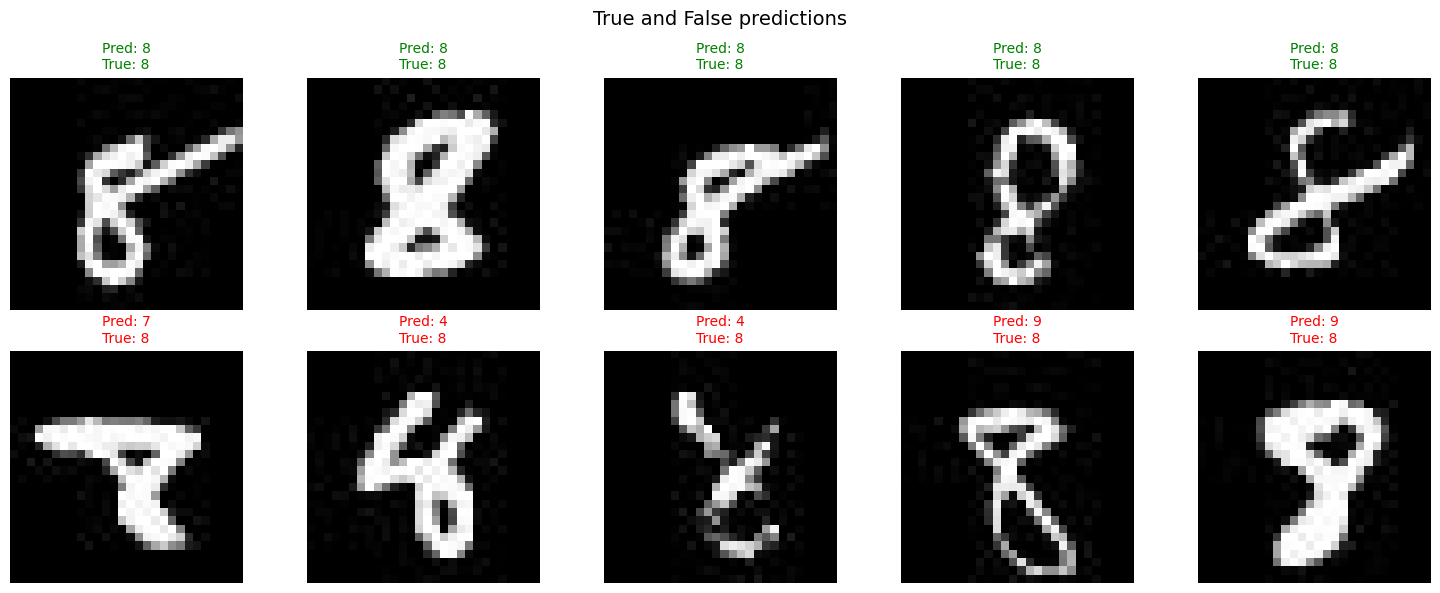

In [ ]:
classes = [str(i) for i in range(10)]  # список классов
show_correct_and_wrong(model, test_loader, classes, device, num_correct=5, num_wrong=5)

**ПРОВЕРКА ДАТАСЕТА!!!**

In [ ]:
train_data.classes #проверка свойства classes

['class_0',
 'class_1',
 'class_2',
 'class_3',
 'class_4',
 'class_5',
 'class_6',
 'class_7',
 'class_8',
 'class_9']

In [ ]:
for path, dir_list, file_list in os.walk('/content/content/mnist/training'):
  print(f"Путь к папке: {path.split('/')[-1]}")
  print(f"\t -количество папок: {len(dir_list)}")
  print(f"\t -количество файлов: {len(file_list)}")

Путь к папке: training
	 -количество папок: 10
	 -количество файлов: 0
Путь к папке: class_6
	 -количество папок: 0
	 -количество файлов: 5918
Путь к папке: class_3
	 -количество папок: 0
	 -количество файлов: 6131
Путь к папке: class_9
	 -количество папок: 0
	 -количество файлов: 5949
Путь к папке: class_8
	 -количество папок: 0
	 -количество файлов: 5851
Путь к папке: class_1
	 -количество папок: 0
	 -количество файлов: 6742
Путь к папке: class_5
	 -количество папок: 0
	 -количество файлов: 5421
Путь к папке: class_2
	 -количество папок: 0
	 -количество файлов: 5958
Путь к папке: class_7
	 -количество папок: 0
	 -количество файлов: 6265
Путь к папке: class_0
	 -количество папок: 0
	 -количество файлов: 5923
Путь к папке: class_4
	 -количество папок: 0
	 -количество файлов: 5842


In [ ]:
test_data.class_to_idx #проверка свойства class_to_idx

{'class_0': 0,
 'class_1': 1,
 'class_2': 2,
 'class_3': 3,
 'class_4': 4,
 'class_5': 5,
 'class_6': 6,
 'class_7': 7,
 'class_8': 8,
 'class_9': 9}

In [ ]:
#one_hot вектор для каждого класса
for cls, one_hot_position in train_data.class_to_idx.items():
  one_hot_vector = [(i == one_hot_position)*1 for i in range(4)]
  print(f"{cls} => {one_hot_vector}")

AttributeError: 'Subset' object has no attribute 'class_to_idx'

In [ ]:
train_data[2564]

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 6)

In [ ]:
img, one_hot_position = train_data[2564]
cls = train_data.classes[one_hot_position]

print(f'Класс - {cls}')
plt.imshow(img, cmap='gray')

AttributeError: 'Subset' object has no attribute 'classes'

In [ ]:
%%shell
jupyter nbconvert --to html /content/MultiNN.ipynb

[NbConvertApp] Converting notebook /content/MultiNN.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 523434 bytes to /content/MultiNN.html
